# Long-term potentiation (LTP)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/LTP" folder

In [2]:
data_folder = "data/10-LTP"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.abf")
data_files

Folders:
'data/10-LTP/baseline'
'data/10-LTP/second_induction'
'data/10-LTP/induction'
'data/10-LTP/post_second_induction'
'data/10-LTP/post_induction'
Files:


['data/10-LTP/group6_induction2.abf',
 'data/10-LTP/group6_post2.abf',
 'data/10-LTP/group6_baseline.abf',
 'data/10-LTP/group6_post.abf',
 'data/10-LTP/group6_baseline2.abf',
 'data/10-LTP/group6_induction.abf']

### **If the data is divided in exactly 3 files** ('baseline', 'induction', and 'post_induction'), copy/paste the names here below 


In [3]:
data_files_baseline = ['data/10-LTP/group6_baseline.abf']
data_files_post = ['data/10-LTP/group6_post.abf']

### If you ran the code window above, the you should skip the next one

### **If the data is spread across many files**, group them together into into 3 folders ('baseline', 'induction', and 'post_induction'):

Double check that the folder names are correct here:

In [4]:
################################################################################################
##### Only run this cell if your data is split into multiple .abf files for each condition #####
################################################################################################

# Select all the data files for each condition
data_folder_baseline = 'data/10-LTP/baseline/'
data_folder_post = 'data/10-LTP/post_induction/'

# -------------------------------------------------------------------------------------------------
data_files_baseline = [f"{data_folder_baseline}/{f}" for f in os.listdir(data_folder_baseline) if f.endswith('.abf')]
data_files_baseline.sort()
data_files_post = [f"{data_folder_post}/{f}" for f in os.listdir(data_folder_post) if f.endswith('.abf')]
data_files_post.sort()

# data_folder_post2 = 'data/10-LTP/post_second_induction/'
# data_files_post2 = [f"{data_folder_post2}/{f}" for f in os.listdir(data_folder_post2) if f.endswith('.abf')]
# data_files_post2.sort()
# data_files_post = data_files_post + data_files_post2

print(f"Num baseline files: {len(data_files_baseline)}")
print(f"Num post files: {len(data_files_post)}")

Num baseline files: 3
Num post files: 29


We will load all the traces from across all files and combine them into a single Trace object

In [ ]:
traces_baseline = combine_traces_across_files(data_files_baseline, average_across_sweeps=False, recording_mode="I clamp")
num_baseline_traces = traces_baseline.num_sweeps

traces_post = combine_traces_across_files(data_files_post, average_across_sweeps=False, recording_mode="I clamp")
num_post_traces = traces_post.num_sweeps

Trace('combined_traces')
Number of sweeps: 311
Points per sweep: 25,000
Duration per sweep: 0.500 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage, TTL


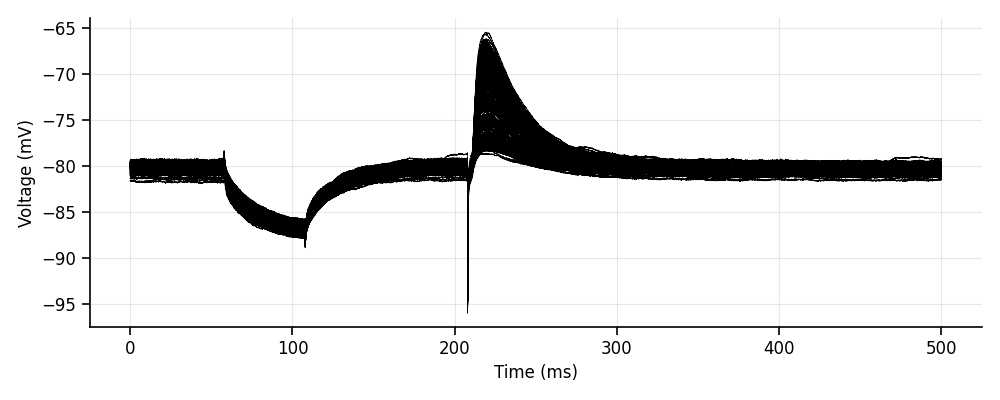

In [ ]:
all_files = data_files_baseline + data_files_post
traces = combine_traces_across_files(all_files, average_across_sweeps=False, recording_mode="I clamp")
traces.num_baseline_sweeps = num_baseline_traces
traces.num_post_sweeps = num_post_traces
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax = traces.plot(plot_voltage=True, plot_current=False, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [27]:
apply_filtering = False

You can run this next cell as many times as you want to fine-tune the filtering parameters:

In [28]:
if apply_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

    # Step 4: Highpass filter (removes low-frequency oscillations)
    # ------------------------------------------------------------
    # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # ------------------------------------------------------------

    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [29]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [39]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True
start_baseline = 56
end_baseline = 57

BASELINE SUBTRACTED:
Baseline voltages: [ 0.2831  0.2118  0.0134 ...  0.0246  0.1327 -0.0168]


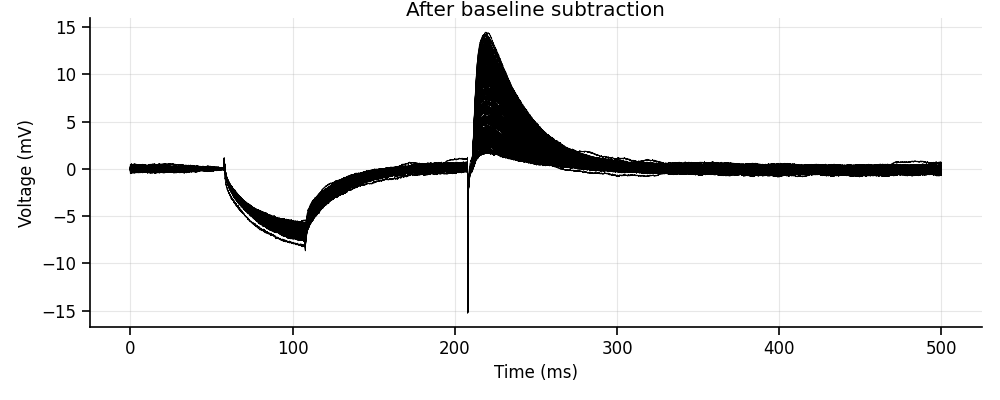

In [40]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'voltage')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


## 3. Select what you want to measure

### 3.1. Measure the test pulse

First let's measure the test pulse to monitor for changes in the access resistance.

We need to define the relevant time window where we want to measure:

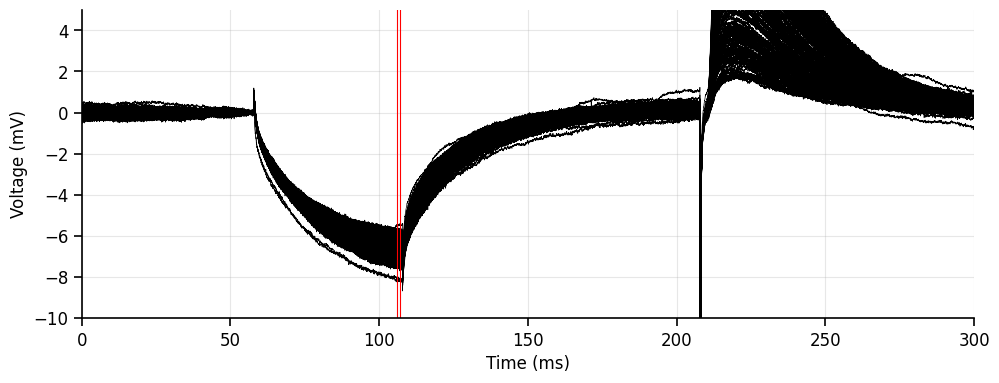

In [ ]:
# The start/end time just helps to zoom in on the traces.
start_time = 0
end_time = 300
# y_axis_range = (-10, 5)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 106
marker_2 = 107

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(start_time,end_time)
ax1.set_ylim(y_axis_range)
plt.show()

Next we will be using the timepoints from the markers we defined above.

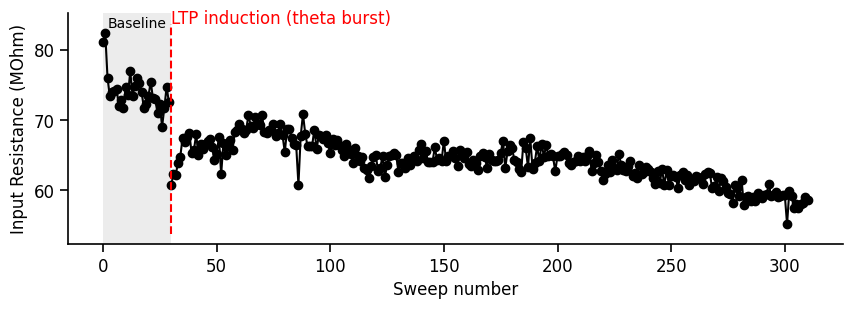

In [45]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

current_steps, voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                           measurement_type=measurement_type, time_units=time_units)


test_pulse_current = -0.1 #nA
resistance = voltage_steps/test_pulse_current #mV / nA = MOhm

%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,resistance[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, resistance[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
ax.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('Input Resistance (MOhm)')
ax.set_xlabel('Sweep number')
plt.show()

### 3.2. Measure the bridge balance

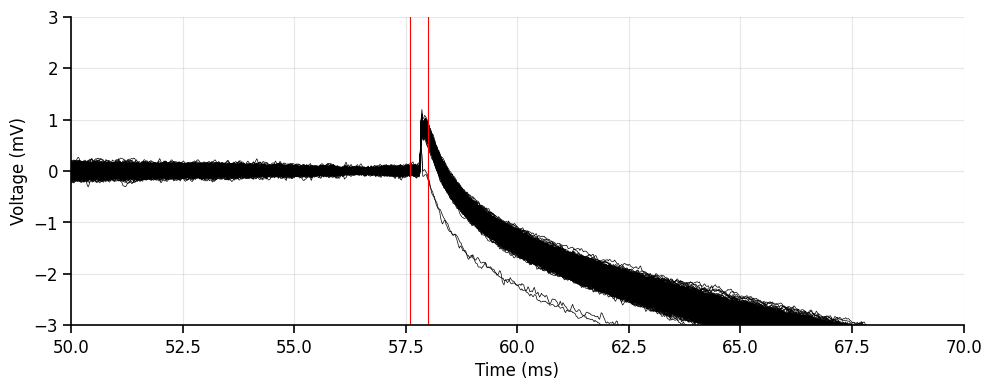

In [ ]:
# The start/end time just helps to zoom in on the traces.
start_time = 50
end_time = 70
y_axis_range = (-3, 3)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 57.6
marker_2 = 58

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(start_time,end_time)
ax1.set_ylim(y_axis_range)
plt.show()

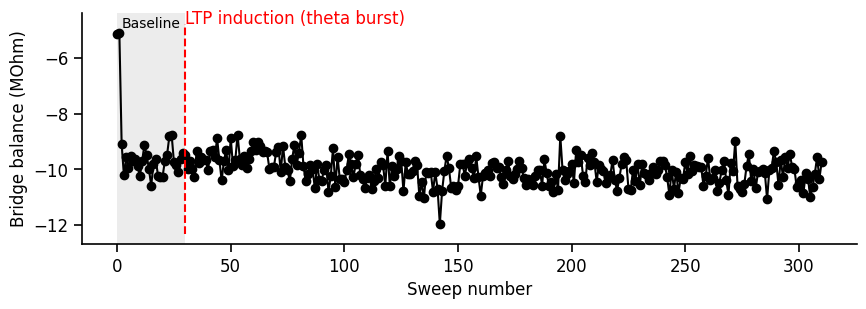

In [52]:
measurement_type = 'max' # Options: 'mean', 'max', 'min', 'peak'

_, voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                           measurement_type=measurement_type, time_units=time_units)


test_pulse_current = -0.1 #nA
resistance = voltage/test_pulse_current #mV / nA = MOhm

%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,resistance[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, resistance[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
ax.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('Bridge balance (MOhm)')
ax.set_xlabel('Sweep number')
plt.show()

### 3.3. Measure the stim artifact (capacitive transient)

First let's re-baseline the data to just before the stimulus.

BASELINE SUBTRACTED:
Baseline voltages: [ 0.0287  0.083   0.1133 ...  0.0754 -0.0474  0.0765]


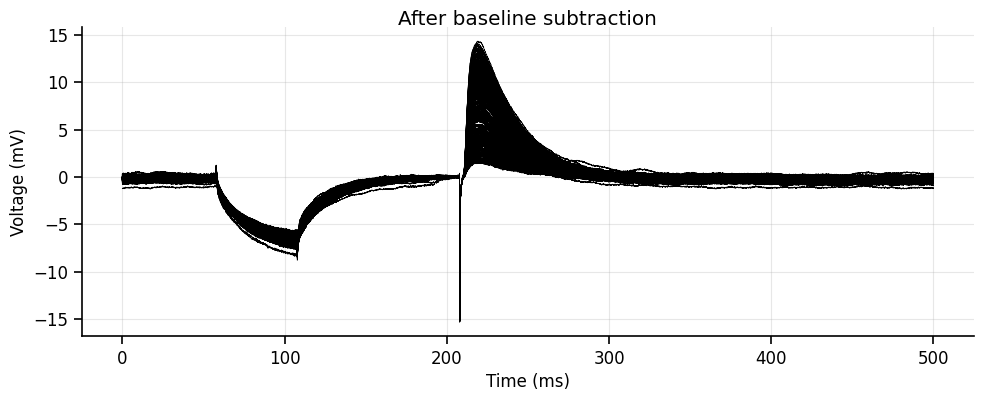

In [57]:
# Change this to True if you want to subtract the baseline from the sweeps.
start_baseline = 205
end_baseline = 206

traces.subtract_baseline(start_time = start_baseline, 
                        end_time = end_baseline , 
                        time_units = time_units,
                        channel = 'voltage')
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
ax1.set_title('After baseline subtraction', y=0.98)
plt.show()

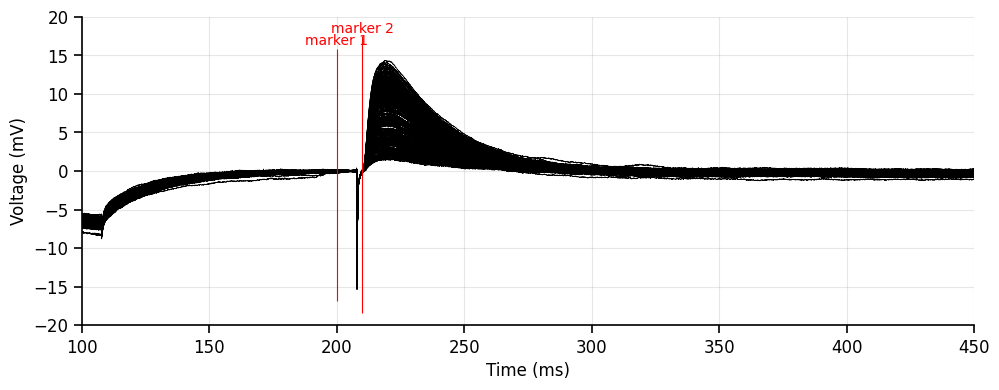

In [62]:
# The start/end time just helps to zoom in on the traces.
start_time = 100
end_time = 450
y_axis_range = (-20, 20)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 200
marker_2 = 210
time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(start_time,end_time)
ax1.set_ylim(y_axis_range)
plt.show()

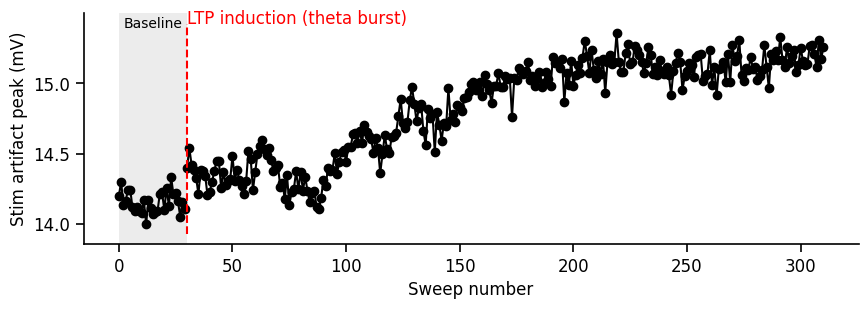

In [63]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                           measurement_type=measurement_type, time_units=time_units)

voltage = np.abs(voltage)

%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,voltage[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, voltage[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
ax.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('Stim artifact peak (mV)')
ax.set_xlabel('Sweep number')
plt.show()

### 3.4. Measure the first EPSP amplitude

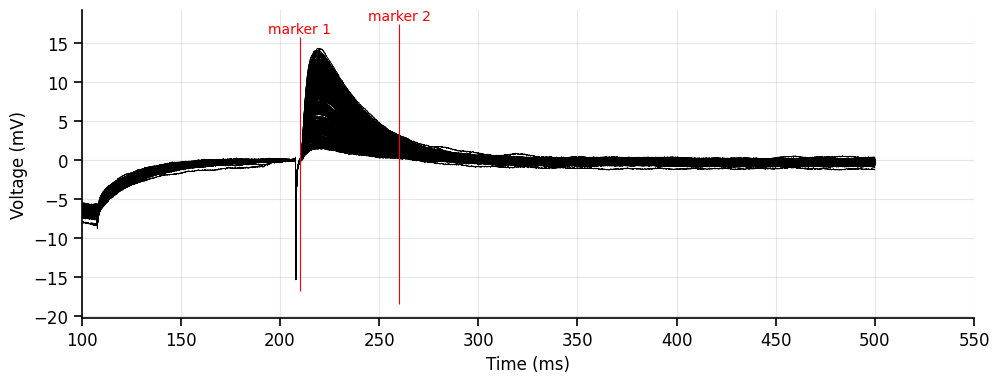

In [64]:
# The start/end time just helps to zoom in on the traces.
start_time = 100
end_time = 550
# y_axis_range = (-5, 50)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 210
marker_2 = 260
time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(start_time,end_time)
# ax1.set_ylim(y_axis_range)
plt.show()

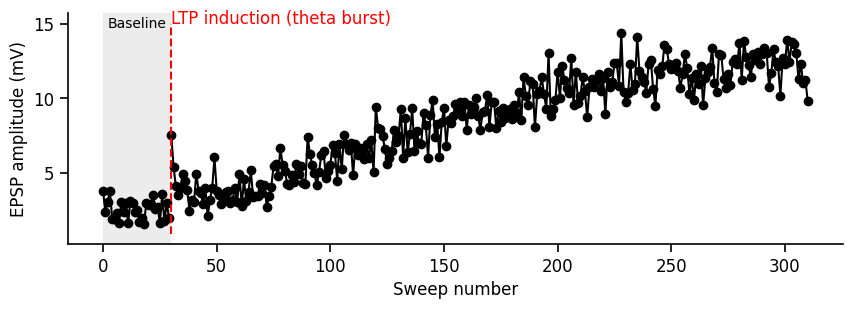

In [65]:
measurement_type = 'max' # Options: 'mean', 'max', 'min', 'peak'

_, voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                    measurement_type=measurement_type, time_units=time_units)


%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,voltage[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, voltage[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
plt.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Sweep number')
plt.show()

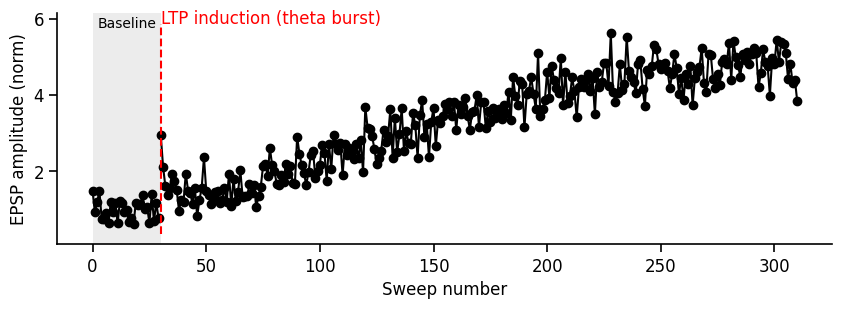

In [66]:
avg_baseline_EPSP = np.mean(voltage[0:traces.num_baseline_sweeps])
normalized_EPSP_amplitudes = voltage / avg_baseline_EPSP

%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,normalized_EPSP_amplitudes[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2,normalized_EPSP_amplitudes[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
plt.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('EPSP amplitude (norm)')
ax.set_xlabel('Sweep number')
plt.show()

### **Optional: If you stimulated with paired-pulse (2 stimuli)**

### 3.4. Measure the second EPSP amplitude

BASELINE SUBTRACTED:
Baseline voltages: [-0.2839  0.1047 -0.1014 ... -0.0697 -0.1158  0.1312]


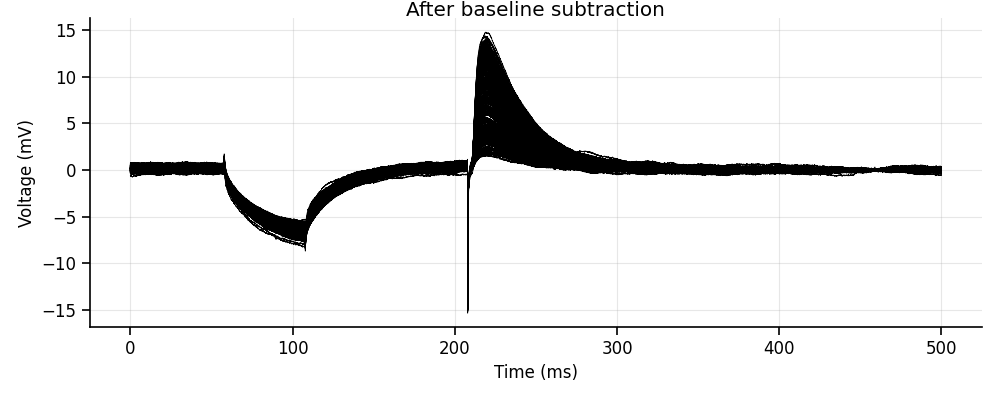

In [23]:
# Change this to True if you want to subtract the baseline from the sweeps.
start_baseline = 459
end_baseline = 459.5

traces.subtract_baseline(start_time = start_baseline, 
                        end_time = end_baseline , 
                        time_units = time_units,
                        channel = 'voltage')
%matplotlib widget
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
ax1.set_title('After baseline subtraction', y=0.98)
plt.show()

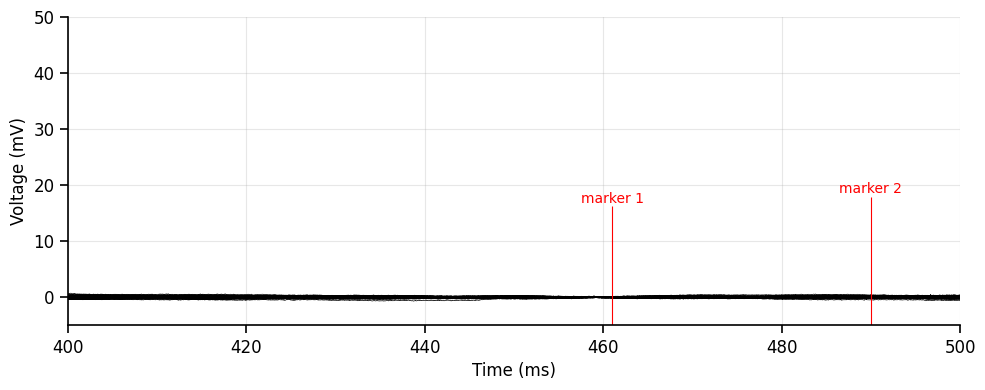

In [24]:
# The start/end time just helps to zoom in on the traces.
start_time = 400
end_time = 500
y_axis_range = (-5, 50)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 461
marker_2 = 490
time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(start_time,end_time)
ax1.set_ylim(y_axis_range)
plt.show()

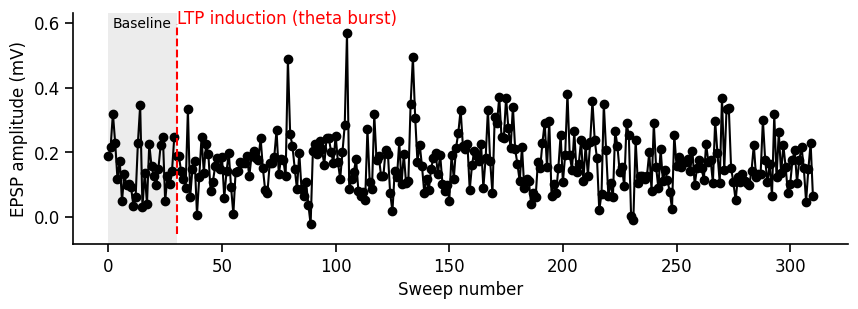

In [25]:
measurement_type = 'max' # Options: 'mean', 'max', 'min', 'peak'

_, voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                    measurement_type=measurement_type, time_units=time_units)


%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,voltage[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, voltage[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
plt.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Sweep number')
plt.show()

### Bonus: Rainbow power!

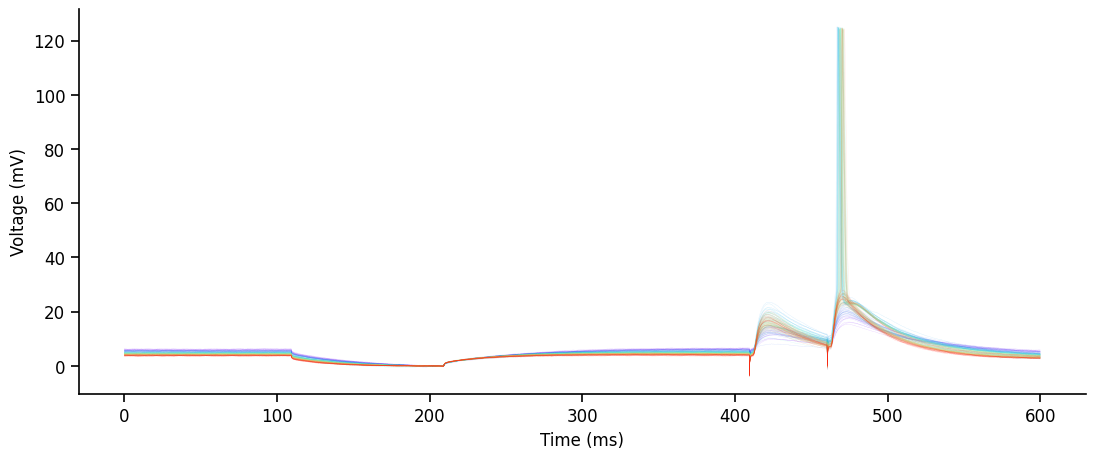

In [ ]:
# cmap = plt.get_cmap('inferno')
# cmap = plt.get_cmap('Reds')
# cmap = plt.get_cmap('spring')
cmap = plt.get_cmap('rainbow')

fig, ax = plt.subplots(figsize=(13, 5))
for i in range(traces.num_sweeps):
    ax.plot(traces.time_ms, traces.voltage_data[i], color=cmap(i/traces.num_sweeps), linewidth=0.2, alpha=0.2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
# ax.set_ylim(-10, 16)
# ax.set_xlim(0, 400)

plt.show()